<a href="https://colab.research.google.com/github/sbmoyano/data_science_projects/blob/master/fraud_detection/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Through this notebook I intend to build a Multilayer Perceptron model using Tensorflow.

**MODEL TRAINING**

As I am already aware of the imbalance of our dataset, I will first **compute the weights for each class** in order to use it during model training.

* First, I will train a very basic model with **ReLu** activation function and **Adam** as our optimizer. Before deciding for ReLu function and the Adam optimizer, I tried different activation functions and optimizers, with ReLu + Adam giving us the best scores, so I will go for this combination.

* Second, I will compute an initial bias for the output layer of the model due to the imbalance of the classes. I will test if adding this bias actually helps to improve model performance.

* Finally, I will test some regularization techniques in case I detect that the model could be overfitting.

**EXPLORING DIFFERENT DECISION THRESHOLDS**

Another idea that I would like to try with this model is to **explore different decision thesholds**, not only the dafault 0.5. As it could be easily implementend passing a list of thresholds to the scores in Tensorflow, I will explore if a higher threshold gives us better results.

**HYPERPARAMETER TUNING**

Finally, once I have decided our decision threshold I will **tune the hyperparameters** of the model using Keras Tuner. I have implemented a custom function that allows to choose between Hyperband or RandomSearch. I will probably use RandomSearch as it is faster than Hyperband, and due to limitations in GPU use in Google Colab, I will have reduce searching times.

**EARLY STOPPING**

Again, due to limitation in Google Colab for GPU use, I will use early stopping to reduce training times if I see that CPU is too slow. When used, I will focus early stopping in monitoring the validation loss, as it offers more variability compared to AUC, which is quite high since the first training epochs.

## Install or update libraries for Google Colab

In [ ]:
! pip install optuna
! pip install -q -U keras-tuner
! pip install tensorflow-addons
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 12.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 30.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 20.7 MB/s eta 0:00:00


# Set environment

# Import libraries

In [ ]:
# manage paths
import sys

# Data manipulation
import pandas as pd
import numpy as np
import os
import datetime
import json

# Visualization
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
import matplotlib.pyplot as plt
import shap

# feature engineering
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

# pipeline
from sklearn.pipeline import Pipeline

# tensorflow
import tensorflow.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Dropout
from keras.constraints import maxnorm
import keras_tuner as kt
from tensorflow.python.framework.ops import enable_eager_execution
enable_eager_execution()

# hyperparameter tuning
import optuna
from optuna.samplers import RandomSampler

Instructions for updating:
non-resource variables are not supported in the long term


TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 



In [ ]:
device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
  raise SystemError("GPU device not found")

print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
tf.executing_eagerly()

True

# Paths

In [ ]:
# create directories if they do not exist in Jupyter Notebook
models_dir = os.path.join(os.getcwd(), ".models")
scores_dir = os.path.join(os.getcwd(), ".scores")
data_dir = os.path.join(os.getcwd(), ".data")

if not models_dir:
    os.makedirs(models_dir)
if not scores_dir:
    os.makedirs(scores_dir)
if not data_dir:
    os.makedirs(data_dir)

# Import data

I will import the same data that I have already used with XGBoost and LightGBM, keeping the same splits for train, test and validation sets.

I will import the datasets as pandas DataFrames in order to have the labels of the different features that I am using, as well as Numpy arrays already splitted into X and y sets for train, test and validation.

In [ ]:
# connect to GoogleDrive on Colab to import stored data there
from google.colab import drive
drive.mount("/content/drive")

# set GoogleDrive the current working directory
%cd /content/drive/My\ Drive

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
# path for Colab
sys.path.append("drive/MyDrive/GITHUB/data_science_projects/fraud_detection/")

# path to import pandas and Numpy files
root_path_gd = os.path.join(os.getcwd(), "GITHUB/data_science_projects/fraud_detection/")
data_path_gd = os.path.join(root_path_gd, ".data/")
models_path_gd = os.path.join(root_path_gd, ".models/")

In [ ]:
def import_data(numpy=True, environment="jupyter"):

  """
  Import data on a Jupyter notebook or on Google Colab.

  Input:
    numpy (bool): True to import data in Numpy format. For pandas DataFrame set
                  it to False.
    environment (str): Either 'jupyter' or 'colab'. If other string is introduced
                       it will raise an exception.

  Output:
    preprocessed data: it will include pandas DataFrames and Numpy arrays. It
                       will return X_train, X_val, X_test, y_train, y_val and
                       y_test as Numpy arrays. Moreover, it will return df_train,
                       df_val and df_test as pandas DataFrames. The latter will
                       be used when preparing data for the LSTM model.
  """

  if environment == "jupyter":
    if numpy:

    # import on Jupyter Notebook
      X_train = np.load(os.path.join(os.getcwd(), ".data/.processed/X_train_np.npy"))
      X_test = np.load(os.path.join(os.getcwd(), ".data/.processed/X_test_np.npy"))
      X_val = np.load(os.path.join(os.getcwd(), ".data/.processed/X_val_np.npy"))
      y_train = np.load(os.path.join(os.getcwd(), ".data/.processed/y_train_np.npy"))
      y_test = np.load(os.path.join(os.getcwd(), ".data/.processed/y_test_np.npy"))
      y_val = np.load(os.path.join(os.getcwd(), ".data/.processed/y_val_np.npy"))

    else:
      X_train = pd.read_csv(os.path.join(os.getcwd(), ".data/.processed/X_train_df.csv"), index_col=0)
      X_test = pd.read_csv(os.path.join(os.getcwd(), ".data/.processed/X_test_df.csv"), index_col=0)
      X_val = pd.read_csv(os.path.join(os.getcwd(), ".data/.processed/X_val_df.csv"), index_col=0)
      y_train = pd.read_csv(os.path.join(os.getcwd(), ".data/.processed/y_train_df.csv"), index_col=0)
      y_test = pd.read_csv(os.path.join(os.getcwd(), ".data/.processed/y_test_df.csv"), index_col=0)
      y_val = pd.read_csv(os.path.join(os.getcwd(), ".data/.processed/y_val_df.csv"), index_col=0)

  elif environment == "colab":
    if numpy:
      X_train = np.load(os.path.join(data_path_gd, ".processed/X_train_np.npy"))
      X_test = np.load(os.path.join(data_path_gd, ".processed/X_test_np.npy"))
      X_val = np.load(os.path.join(data_path_gd, ".processed/X_val_np.npy"))
      y_train = np.load(os.path.join(data_path_gd, ".processed/y_train_np.npy"))
      y_test = np.load(os.path.join(data_path_gd, ".processed/y_test_np.npy"))
      y_val = np.load(os.path.join(data_path_gd, ".processed/y_val_np.npy"))
    else:
      X_train = pd.read_csv(os.path.join(data_path_gd, ".processed/X_train_df.csv"), index_col=0)
      X_test = pd.read_csv(os.path.join(data_path_gd, ".processed/X_test_df.csv"), index_col=0)
      X_val = pd.read_csv(os.path.join(data_path_gd, ".processed/X_val_df.csv"), index_col=0)
      y_train = pd.read_csv(os.path.join(data_path_gd, ".processed/y_train_df.csv"), index_col=0)
      y_test = pd.read_csv(os.path.join(data_path_gd, ".processed/y_test_df.csv"), index_col=0)
      y_val = pd.read_csv(os.path.join(data_path_gd, ".processed/y_val_df.csv"), index_col=0)

  else:
    raise Exception("Environment not supported. Try 'jupyter' or 'colab'")

  return X_train, X_test, X_val, y_train, y_test, y_val

In [ ]:
# load data in pandas DataFrames to show the data available and columns
X_train_df, X_test_df, X_val_df, y_train_df, y_test_df, y_val_df = import_data(numpy=False, environment="colab")

display(X_train_df)
print("\n")
print(X_train_df.columns)

,day,week,is_weekend,amt_log,merch_lat,merch_long,total_seconds_day,hour,age,zip,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,-1.643389,-1.781587,-0.757357,-1.060622,1.064712,-1.416337,-0.076532,-0.118803,-0.737671,1.253131,...,0,0,0,0,1,0,0,0,0,0
1,-1.531258,-1.781587,-0.757357,0.369892,0.681984,-1.365695,-0.668388,-0.705570,-0.737671,1.253131,...,0,0,0,0,0,0,0,0,0,0
2,-1.531258,-1.781587,-0.757357,0.685878,0.866421,-1.373925,-0.661915,-0.705570,-0.737671,1.253131,...,0,0,0,0,0,0,0,0,0,0
3,-1.531258,-1.781587,-0.757357,0.067388,0.722970,-1.344176,-0.098557,-0.118803,-0.737671,1.253131,...,0,0,0,1,0,0,0,0,0,0
4,-1.531258,-1.781587,-0.757357,-0.110475,0.936944,-1.296524,-0.019089,0.027889,-0.737671,1.253131,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942975,-0.858473,-1.716530,-0.757357,1.055428,0.680890,0.014691,0.529899,0.467964,1.048127,0.465901,...,0,0,0,1,0,0,0,0,0,0
942976,-0.634212,-1.716530,-0.757357,-0.861828,0.548325,0.045668,0.856401,0.908039,1.048127,0.465901,...,0,0,0,0,0,0,0,0,0,0
942977,-0.634212,-1.716530,-0.757357,-0.089831,0.432065,0.001886,1.210872,1.201423,1.048127,0.465901,...,0,0,0,1,0,0,0,0,0,0
942978,-0.522081,-1.716530,1.320381,-2.082384,0.612072,0.099774,-1.203778,-1.145646,1.048127,0.465901,...,0,0,0,0,0,1,0,0,0,0




Index(['day', 'week', 'is_weekend', 'amt_log', 'merch_lat', 'merch_long',
       'total_seconds_day', 'hour', 'age', 'zip', 'month', 'city_pop',
       'amt_week_quarter', 'amt_day_7d_merch', 'amt_day_30d_merch',
       'amt_day_30d_cat', 'amt_day_7d_cat', 'amt_day_month_merch_quarter',
       'amt_day_week_merch_quarter', 'cumsum_amt_day', 'cumcount_trans_day',
       'cumcount_trans_month_merch', 'time_since_last_trans', 'lag_fraud',
       'distance', 'gender_m', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel'],
      dtype='object')


In [ ]:
# load data
X_train, X_test, X_val, y_train, y_test, y_val = import_data(numpy=True, environment="colab")

display(X_train)
print("\n")
display(y_train)

array([[-1.64338887, -1.78158721, -0.75735714, ...,  0.        ,
         0.        ,  0.        ],
       [-1.5312581 , -1.78158721, -0.75735714, ...,  0.        ,
         0.        ,  0.        ],
       [-1.5312581 , -1.78158721, -0.75735714, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.63421191, -1.71653013, -0.75735714, ...,  0.        ,
         0.        ,  0.        ],
       [-0.52208113, -1.71653013,  1.32038104, ...,  0.        ,
         0.        ,  0.        ],
       [-0.52208113, -1.71653013,  1.32038104, ...,  0.        ,
         0.        ,  0.        ]])

array([0, 0, 0, ..., 0, 0, 0])

# Custom functions

## Confusion matrix

In [ ]:
def conf_matrix_clf_report(y_true, y_pred, scores, print_info=True):

  """
  Returns a classification report and confusion matrix for the predictions of
  the model.

  Input:
    predictions (Numpy array): Numpy array of the predictions bt the trained
                               model.
    y (Numpy array): Numpy array with the ground truth.
    scores (dictionary): dictionary with scores return by the model.
    print_info (bool): boolean value to print additional information. If set to
                       True it will print more information.

  Output:
    clf_rep (DataFrame): pandas DataFrame with classification report.
    conf_mtx (DataFrame): pandas DataFrame with confusion matrix.
  """

  # classifcation report and confusion matrix
  clf_rep = pd.DataFrame(classification_report(y_true, y_pred,
                                               output_dict=True)).T
  # build confusion matrix DataFrame
  conf_mtx = pd.DataFrame(columns=["non-fraud (pred)",
                                   "fraud (pred)"],
                          index=["non-fraud (true)",
                                 "fraud (true)"])

  conf_mtx.loc["fraud (true)"]["fraud (pred)"] = scores["tp"]
  conf_mtx.loc["fraud (true)"]["non-fraud (pred)"] = scores["fn"]
  conf_mtx.loc["non-fraud (true)"]["fraud (pred)"] = scores["fp"]
  conf_mtx.loc["non-fraud (true)"]["non-fraud (pred)"] = scores["tn"]

  TPR = scores["tp"]/(scores["tp"]+scores["fn"])

  FPR = scores["fp"]/(scores["fp"]+scores["tn"])

  FNR = scores["fn"]/(scores["fn"]+scores["tp"])

  TNR = scores["tn"]/(scores["tn"]+scores["fp"])

  if print_info:
      print("F1 score: {}".format(
          round(f1_score(y_true, y_pred), 3)))
      print("AUC score: {}".format(round(scores["auc"], 3)))
      print("TPR rate: {}%".format(round(TPR*100, 3)))
      print("FPR rate: {}%".format(round(FPR*100, 3)))
      print("BER score: {}".format(round(0.5*(FPR+FNR), 3)))
      print("G-mean score: {}".format(round(np.sqrt(TPR*TNR), 3)))

  print("\n")
  display(clf_rep)
  print("\n")
  display(conf_mtx)

## Scores for different thresholds

In [ ]:
def get_scores_thresholds(thresholds, model, scores_thresholds):

  """
  Returns a pandas DataFrame with scores for different thresholds of the trained
  model.

  Input:
    thresholds (list): list of the different thresholds used.
    model (Tensorflow model): model trained using the different thresholds
                              specified in threhsolds.
    scores_thresholds (Tensorflow model scores): scores of the trained model on
                                                 the test set.

  Output:
    df_thresholds (DataFrame): pandas DataFrame with scores for each threshold
                               used. Each row contains a different threshold and
                               each column a different score.
  """

  # conf_matrices = {}


  # create empty DataFrame
  df_thresholds = pd.DataFrame()

  for i, threshold in enumerate(thresholds):

      print("Working on result for threshold: {}".format(threshold))

      # create empty dictionary to store values at each iteration
      scores_thresholds_out = {}

      # get model predictions on the test set for each threshold
      predictions_MLP = np.ndarray.flatten((model.predict(X_test, batch_size=128) >
                                            threshold)).astype("int32")

      # extract basic metrics from the dictionary for each threshold
      scores_thresholds_out["Threshold"] = threshold
      scores_thresholds_out["TP"] = scores_thresholds["tp"][threshold]
      scores_thresholds_out["FP"] = scores_thresholds["fp"][threshold]
      scores_thresholds_out["TN"] = scores_thresholds["tn"][threshold]
      scores_thresholds_out["FN"] = scores_thresholds["fn"][threshold]

      # compute TPR, FPR, TNR and FNR
      scores_thresholds_out["TPR"] = (scores_thresholds_out["TP"]/(
          scores_thresholds_out["TP"]+scores_thresholds_out["FN"]))*100
      scores_thresholds_out["FPR"] = (scores_thresholds_out["FP"]/(
          scores_thresholds_out["TN"]+scores_thresholds_out["FP"]))*100
      scores_thresholds_out["FNR"] = (scores_thresholds_out["FN"]/(
          scores_thresholds_out["TP"]+scores_thresholds_out["FN"]))*100
      scores_thresholds_out["TNR"] = (scores_thresholds_out["TN"]/(
          scores_thresholds_out["TN"]+scores_thresholds_out["FP"]))*100

      # BER score
      scores_thresholds_out["BER"] = 0.5*((scores_thresholds_out["FN"]/(
        scores_thresholds_out["TP"]+scores_thresholds_out["FN"]))+scores_thresholds_out["FP"]/(
                                                          scores_thresholds_out["TN"]+scores_thresholds_out["FP"]))

      # G-mean score
      scores_thresholds_out["G-mean"] = np.sqrt(scores_thresholds_out["TPR"]*scores_thresholds_out["TN"]/(
          scores_thresholds_out["TN"]+scores_thresholds_out["FP"]))

      # as I only get one AUC score with evaluate, I will have to predict for
      # each threshold and compute the AUC score
      scores_thresholds_out["F1_micro"] = round(f1_score(y_test,
                                                         predictions_MLP,
                                                         average="micro"), 3)
      scores_thresholds_out["AUC"] = round(roc_auc_score(y_test,
                                                         predictions_MLP), 3)

      # append results for each threshold to a DataFrame
      df_thresholds = df_thresholds.append(scores_thresholds_out, ignore_index=True)

  df_thresholds.set_index("Threshold", inplace=True)

  return df_thresholds

## Plot metrics

In [ ]:
def plot_metrics(history, validation=False):

    """
    Function to plot metrics as lineplots.

    Input:
      history (Keras object): history of the trained model.
      auc_ylim (list of int): list of integers defining the lower and upper
                              limits of the y-axis for the AUC score.
      validation (bool): if set to True, it will also plot a line for the
                         validation scores.
    Output:
      None
    """

    metrics = ["loss", "auc", "TPR", "FPR"]
    colors = ["blue", "orange"]

    history.history["TPR"] = np.array(history.history["tp"])/(np.array(
        history.history["tp"])+np.array(history.history["fn"]))
    history.history["FPR"] = np.array(history.history["fp"])/(
        np.array(history.history["fp"])+np.array(history.history["tn"]))
    history.history["val_TPR"] = np.array(history.history["val_tp"])/(np.array(
        history.history["val_tp"])+np.array(history.history["val_fn"]))
    history.history["val_FPR"] = np.array(history.history["val_fp"])/(
        np.array(history.history["val_fp"])+np.array(history.history["val_tn"]))

    fig, ax = plt.subplots(figsize=(15, 10))

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label="Train")
        if validation:
            plt.plot(history.epoch, history.history["val_"+metric],
                     color=colors[1], linestyle="--", label="Val")
        plt.xlabel("Epoch")
        plt.ylabel(name)
        plt.legend(frameon=False)
        sns.despine()

    if metric == "loss":
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])
    elif metric in ["weighted_auc", "TPR", "FPR"]:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

## Keras tuner

In [ ]:
def select_tuner(tuner, model, project_name):

  """
  Select tuner to use during hyperparameter tuning from Keras. Only two tuners
  are set: RandomSearch and Hyperband. If another tuner is trying to be selected
  it will raise an exception.

  Input:
    tuner (str): string of the selected tuner. Set to 'RandomSearch' in case that
                 tuner wants to be selected. Otherwise 'Hyperband'.
  Output:
    tuner_model (Keras tuner): selected Keras tuner to be fit.
  """

  if tuner == "RandomSearch":

    tuner_model = kt.RandomSearch(model,
                                  objective=kt.Objective("val_loss",
                                                         direction="min"),
                                  max_trials=10,
                                  seed=42,
                                  executions_per_trial=3,
                                  directory=models_path_gd,
                                  project_name=project_name,
                                  overwrite=False)
  elif tuner == "Hyperband":
    tuner_model = kt.Hyperband(model,
                               objective=kt.Objective("val_loss",
                                                      direction="min"),
                               max_epochs=10,
                               factor=3,
                               seed=42,
                               executions_per_trial=3,
                               directory=models_path_gd,
                               project_name=project_name,
                               overwrite=False)
  else:
    raise Except("Tuner not yet implemented in the function. Add it or select 'RandomSearch' or 'Hyperband'")

  return tuner_model

## Early Stopping Callback

In [ ]:
# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                           verbose=1,
                                                           patience=5,
                                                           mode="min",
                                                           restore_best_weights=True)

## Seed

In [ ]:
# set a seed
tf.keras.utils.set_random_seed(42)

# Analysis/Modeling

## Fit a MLP model

### Compute weights

As I have a very imbalanced dataset, I should compute the weights for the different classes in order to be considered during model training. First, let's count the number of fraud (1) and non-fraud (0) transactions to compute this weights. I will compute the weights useing Sklearn compute_class_weight function.

### Define thresholds, metrics, class weights and biases

In [ ]:
# thresholds to use
THRESHOLDS = None

# list of metrics - it raises an error when passed to weighted_metrics=METRICS,
# so I have defined the metrics inside the function
METRICS = [tf.keras.metrics.TruePositives(name="tp", thresholds=THRESHOLDS),
            tf.keras.metrics.FalsePositives(name="fp", thresholds=THRESHOLDS),
            tf.keras.metrics.TrueNegatives(name="tn", thresholds=THRESHOLDS),
            tf.keras.metrics.FalseNegatives(name="fn", thresholds=THRESHOLDS),
            tf.keras.metrics.AUC(name="auc", curve="ROC", thresholds=THRESHOLDS)]

# number of classes to eb specified in the last output layer of the model
NUM_CLASSES = 1

# count number of fraudulent and non-fraudulent transactions
counts = np.bincount(y_train_df["is_fraud"])

# compute class weight
class_weight = compute_class_weight(class_weight="balanced", classes=[0, 1], y=y_train_df["is_fraud"])
CLASS_WEIGHTS = {0: class_weight[0], 1: class_weight[1]}

# set this output bias in "bias_initializer" to reflect data imbalance
OUTPUT_BIAS = tf.keras.initializers.Constant(np.log([counts[1]/counts[0]]))

# print
print("Total number of fraudulent transactions in the training set {}, which represents a {}%".format(counts[1],
                                                                                                      round((counts[1]/counts[0])*100, 2)))
print("\nWe will set the weight for non-fraudulent transactions to {}, while it will be set to {} for the fraudulent ones".format(round(CLASS_WEIGHTS[0], 6),
                                                                                                                                  round(CLASS_WEIGHTS[1], 6)))

Total number of fraudulent transactions in the training set 5343, which represents a 0.57%

We will set the weight for non-fraudulent transactions to 0.502849, while it will be set to 88.244432 for the fraudulent ones


### Weight initilializers based on activation function

### Train a dense model with ReLu activation

Before training the model that is presented in this notebook, I have previously fitted models using Sigmoid, Tahn and ReLu activation functions. I found that ReLu activation offered the best score. That is why in further models I will use "ReLu" activation function an He initialization.

In [ ]:
# get results using He initialization using Sigmoid and Tahn activation function for hidden layers
XAVIER_INIT = tf.keras.initializers.GlorotNormal(seed=42)

# get results using Xavier initialization using ReLu activation functions in hidden layers
HE_INIT = tf.keras.initializers.HeNormal(seed=42)

# dictionary to iterate over
activations_initilizations = {"relu": HE_INIT}#, "sigmoid": XAVIER_INIT, "tanh": XAVIER_INIT}

### Model architecture

I will built a first simple model with two Dense layer of 64 neurons each. I will use a Sigmoid activation function in the output layer as I want our output to be between 0 and 1.

As I have already normalizer our inputs before fitting the model, the classification boundary should be less sensitive to perturbations in the input, which will lead to a better classification. Note that StandardScaler was employed during feature engineering, learning the mean and standard deviation of the training set to normalize the test set.

1. Loss function will be set to be binary crossentropy. Instead of performing over or undersampling, I will pass class weights to account for the imbalance in the dataset.

2. Learning rate: I will set it to the default value, which is 0.001

3. Initialize weights randomly:

    3.1. He initialization: as I am going use ReLu, I will use He initialization as it is recommended for this function.

4. Optimizater: I will use Adam as it gave the best results with ReLu function. As recommended, I will set Beta 1 (Momentum) to 0.9 and Beta 2 (RMSprop to 0.999). I will try different learning rates between 0.001-0.0001. According to Andrew Ng, the epsilon parameter (prevent division from zero error) does not change much model performance, so I am not going to touch it.

5. Regularization techinques: I will consider the use of dropout and early stopping in case of model overfitting.

In [ ]:
def model_MLP(activation_function, kernel_initializer, output_bias,
              num_classes, lr, dropout, thresholds, class_weights):

  model = tf.keras.Sequential()
  # input layer
  model.add(tf.keras.Input(shape=(X_train.shape[-1])))
  # dense layer 1
  model.add(tf.keras.layers.Dense(64,
                                  activation=activation_function,
                                  kernel_initializer=kernel_initializer))
  # dropout 1
  if dropout:
    model.add(tf.keras.layers.Dropout(0.2))

  # dense layer 2
  model.add(tf.keras.layers.Dense(64,
                                  activation=activation_function,
                                  kernel_initializer=kernel_initializer))

  # output layer
  model.add(tf.keras.layers.Dense(num_classes,
                                  activation="sigmoid",
                                  bias_initializer=output_bias))

  # model summary
  model.summary()

  # compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999,
                                                   learning_rate=lr),
                weighted_metrics=[tf.keras.metrics.TruePositives(name="tp", thresholds=thresholds),
                                  tf.keras.metrics.FalsePositives(name="fp", thresholds=thresholds),
                                  tf.keras.metrics.TrueNegatives(name="tn", thresholds=thresholds),
                                  tf.keras.metrics.FalseNegatives(name="fn", thresholds=thresholds),
                                  tf.keras.metrics.AUC(name="auc", curve="ROC", thresholds=thresholds)])

  # get history from model.fit()
  history = model.fit(x=X_train,
                      y=y_train,
                      epochs=50,
                      batch_size=128,
                      validation_data=(X_val, y_val),
                      #callbacks=[early_stopping_callback],
                      verbose=1,
                      class_weight=class_weights)

  # evaluate on the test set
  test_scores = model.evaluate(X_test, y_test, batch_size=128, verbose=1)

  # get dictionary with scores from model.evaluate()
  if type(thresholds) is list:
      # store scores
      dict_test_scores = {"loss": test_scores[0],
                          "tp": dict(zip(thresholds, test_scores[1])),
                          "fp": dict(zip(thresholds, test_scores[2])),
                          "tn": dict(zip(thresholds, test_scores[3])),
                          "fn": dict(zip(thresholds, test_scores[4])),
                          "auc": test_scores[5]} # does not support iterations for zip
  else:
      # store scores
      dict_test_scores = {"loss": test_scores[0],
                          "tp": test_scores[1],
                          "fp": test_scores[2],
                          "tn": test_scores[3],
                          "fn": test_scores[4],
                          "auc": test_scores[5]}

  return model, dict_test_scores, history

#### MLP

First, I will train a MLP model without both, initial bias in the output layer and dropout.

**RESULTS**

I can see in the loss and AUC plot that they are very volatile for the validation set. This makes sense as this set is much more smaller than the training set, and the default learning rate could be too high.

Nevertheless, performance on the test set is not bad, with a TPR of 97.99% and a FPR of .13%, while AUC is also high at .995

I will try to improve the curves of the validation set metric, making them more stable, decreasing the learning rate in the following models. I will do this before trying the output bias, as I am not going to be able to see reliable improvement with such unstable curves.

In [ ]:
tf.keras.backend.clear_session()

# dictionary to store results
out_wout_bias = {}

# iterate over dictionary with different activation functions and initializers
for activation, initilization in activations_initilizations.items():
    model, scores, history = model_MLP(activation, initilization, None, NUM_CLASSES, .001, False, THRESHOLDS, CLASS_WEIGHTS)
    out_wout_bias[activation] = [model, scores, history]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2560      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
7368/7368 [==============================] - 60s 8ms/step - loss: 0.0484 - tp: 461971.5312 - fp: 4971.2969 - tn: 466514.4375 - fn: 9530.4014 - auc: 0.9976 - val_loss: 0.0755 - val_tp: 2124.0000 - val_fp: 6536.0000 - val_tn: 342552.0000 - val_fn: 15.0000 - val_auc: 0.9980
Epoch 2/50
7368/7368 [==============================] - 45s 6ms/step - loss: 0.0276 - tp: 466384.3750 - fp: 4156.6050 - tn: 467330.0000 - fn: 5118.1772 - auc: 0.9993 - val_loss: 0.0242 - val_tp: 2114.0000 - val_fp: 3059.0000 - val_tn: 346029.0000 - val_fn: 25.0000 - val_auc: 0.9994
Epoch 3/50
7368/7368 [==============================] - 49s 7ms/step - loss: 0.0213 - tp: 467354.9062 - fp: 3212.7263 - tn: 468275.8438 - fn: 4147.4868 - auc: 0.9993 - val_loss: 0.0330 - val_tp: 2134.0000 - val_fp: 3836.0000 - val_tn: 345252.0000 - val_fn: 5.0000 - val_auc: 0.9994
Epoch 4/50
7368/7368 [==============================] - 51s 7ms/step - loss: 0.0157 - tp: 468943.7500 - fp: 2337.2290 - tn: 469155.0000 - fn: 2559.0879 

In [ ]:
# extract model, scores and history from the model
model_MLP_nobias, scores_MLP_nobias, history_MLP_nobias = out_wout_bias["relu"]

##### Plot results

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


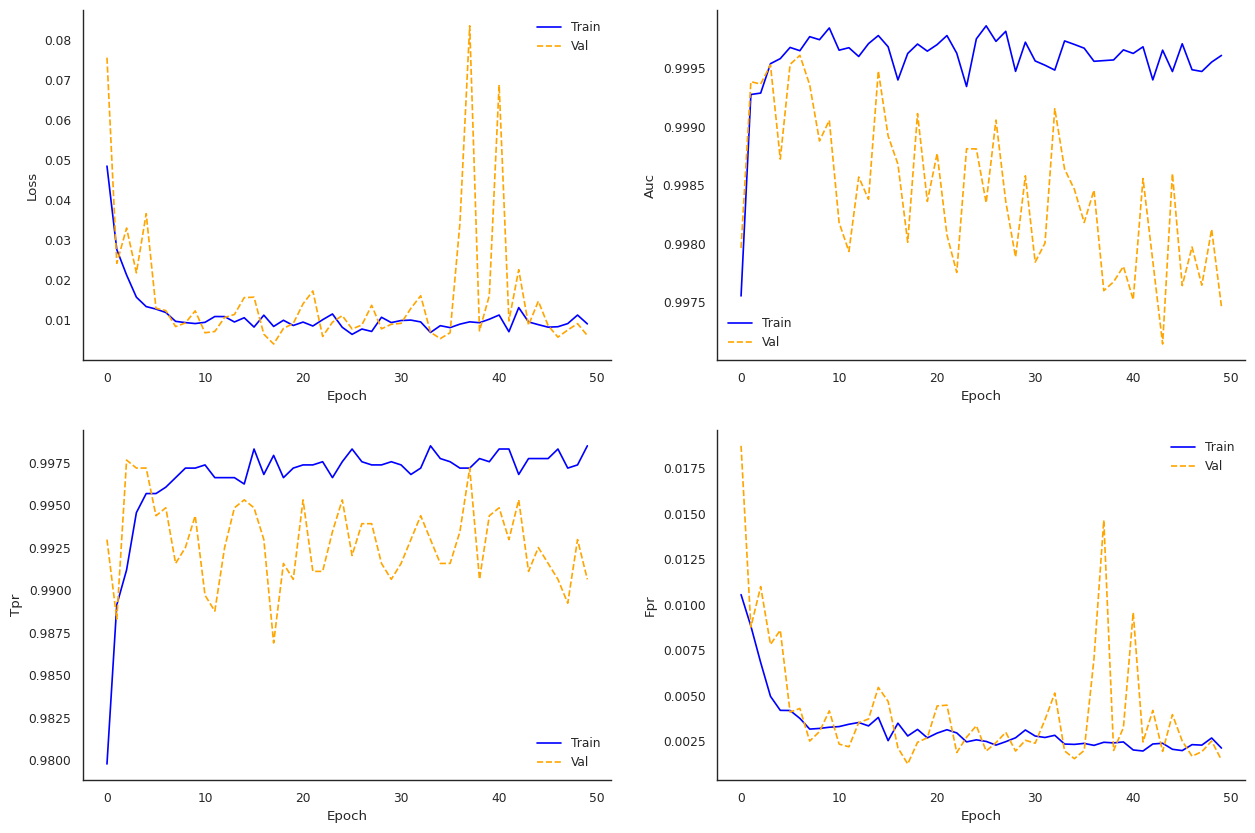

In [ ]:
plot_metrics(history_MLP_nobias, validation=True)

##### Predictions

In [ ]:
predictions_MLP_nobias = np.ndarray.flatten((model_MLP_nobias.predict(X_test, batch_size=128) > 0.5)).astype("int32")

print("ReLu activation functions: Shape for predictions {} equals shape of the ground truth {}".format(predictions_MLP_nobias.shape, y_test.shape))

4342/4342 [==============================] - 7s 2ms/step
ReLu activation functions: Shape for predictions (555719,) equals shape of the ground truth (555719,)


##### Confusion matrix

In [ ]:
cm = conf_matrix_clf_report(y_test, predictions_MLP_nobias, scores_MLP_nobias, print_info=True)

F1 score: 0.844
AUC score: 0.995
TPR rate: 97.995%
FPR rate: 0.133%
BER score: 0.011
G-mean score: 0.989




,precision,recall,f1-score,support
0,0.999922,0.998672,0.999297,553574.0000
1,0.740924,0.979953,0.843838,2145.0000
accuracy,0.998600,0.998600,0.998600,0.9986
macro avg,0.870423,0.989313,0.921567,555719.0000
weighted avg,0.998923,0.998600,0.998697,555719.0000


,non-fraud (pred),fraud (pred)
non-fraud (true),552839.0,735.0
fraud (true),43.0,2102.0


#### MLP reducing learning rate

In this model I will only change the learning rate from the default .001, to .0001 and .00001 to see if I can stabilize the loss curve of the validation set.

**RESULTS**

As I can see, reducing the learning rate from .001 to .0001 and .00001 significantly improves the loss curve of the validation set.

Although the lowest learning rate (.00001) returns a better looking curve for all metrics, it increase the FPR, which it is not desireable.

On the other hand, a learning rate of .0001 leads to certain model overfitting, with AUC and TPR for the training set being higher than the validation set.

I can see the comparison in FPRs and TPRs in the test set in the following lists (*in bold the best scores*):

* FPR (learning rate .001): .13
* **FPR (learning rate .0001): .09**
* FPR (learning rate .00001): .63


* **TPR (learning rate .001): 97.99**
* TPR (learning rate .0001): 97.94
* TPR (learning rate .00001): 97.94

Before deciding which learning rate I am going to keep. Lets's try both with the initial bias in the output layer to see which one return a better performence.

In [ ]:
tf.keras.backend.clear_session()

# dictionary to store results
out_nobias_lr = {}

# iterate over dictionary with different activation functions and initializers
for activation, initilization in activations_initilizations.items():
    model, scores, history = model_MLP(activation, initilization, None, NUM_CLASSES, .00001, False, THRESHOLDS, CLASS_WEIGHTS)
    out_nobias_lr[activation] = [model, scores, history]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2560      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
7368/7368 [==============================] - 45s 6ms/step - loss: 0.5797 - tp: 407963.8750 - fp: 228073.3906 - tn: 243414.8594 - fn: 63536.4414 - auc: 0.8409 - val_loss: 0.2242 - val_tp: 2034.0000 - val_fp: 16128.0000 - val_tn: 332960.0000 - val_fn: 105.0000 - val_auc: 0.9856
Epoch 2/50
7368/7368 [==============================] - 44s 6ms/step - loss: 0.1180 - tp: 451470.4688 - fp: 12334.6328 - tn: 459136.7500 - fn: 20031.4570 - auc: 0.9917 - val_loss: 0.0977 - val_tp: 2077.0000 - val_fp: 6418.0000 - val_tn: 342670.0000 - val_fn: 62.0000 - val_auc: 0.9960
Epoch 3/50
7368/7368 [==============================] - 48s 7ms/step - loss: 0.0745 - tp: 457294.6562 - fp: 6490.0391 - tn: 464986.0312 - fn: 14207.3398 - auc: 0.9957 - val_loss: 0.0702 - val_tp: 2092.0000 - val_fp: 5311.0000 - val_tn: 343777.0000 - val_fn: 47.0000 - val_auc: 0.9976
Epoch 4/50
7368/7368 [==============================] - 45s 6ms/step - loss: 0.0610 - tp: 459766.1875 - fp: 5597.4023 - tn: 465881.5000 - fn: 1

In [ ]:
# extract model, scores and history from the model
model_MLP_nobias_lr, scores_MLP_nobias_lr, history_MLP_nobias_lr = out_nobias_lr["relu"]

##### Plot results

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


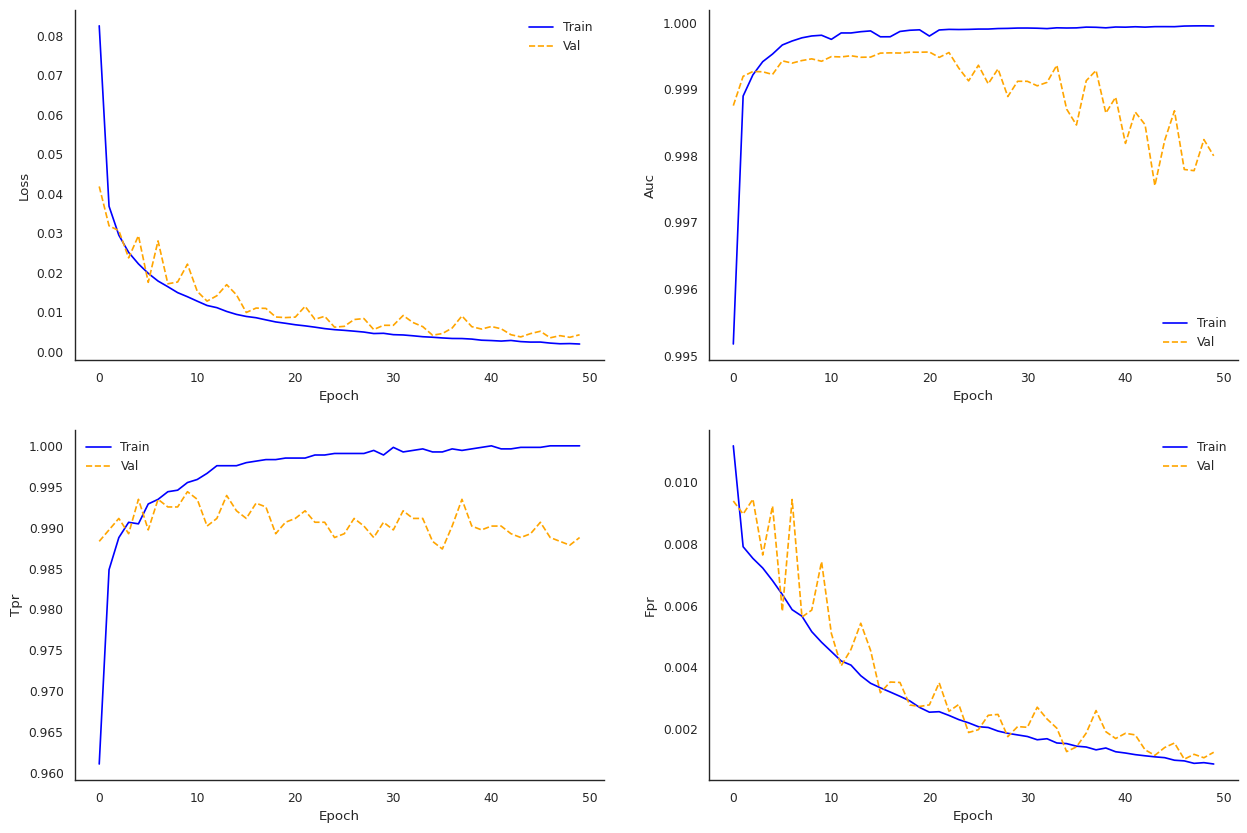

In [ ]:
# learning rate .0001
plot_metrics(history_MLP_nobias_lr, validation=True)

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


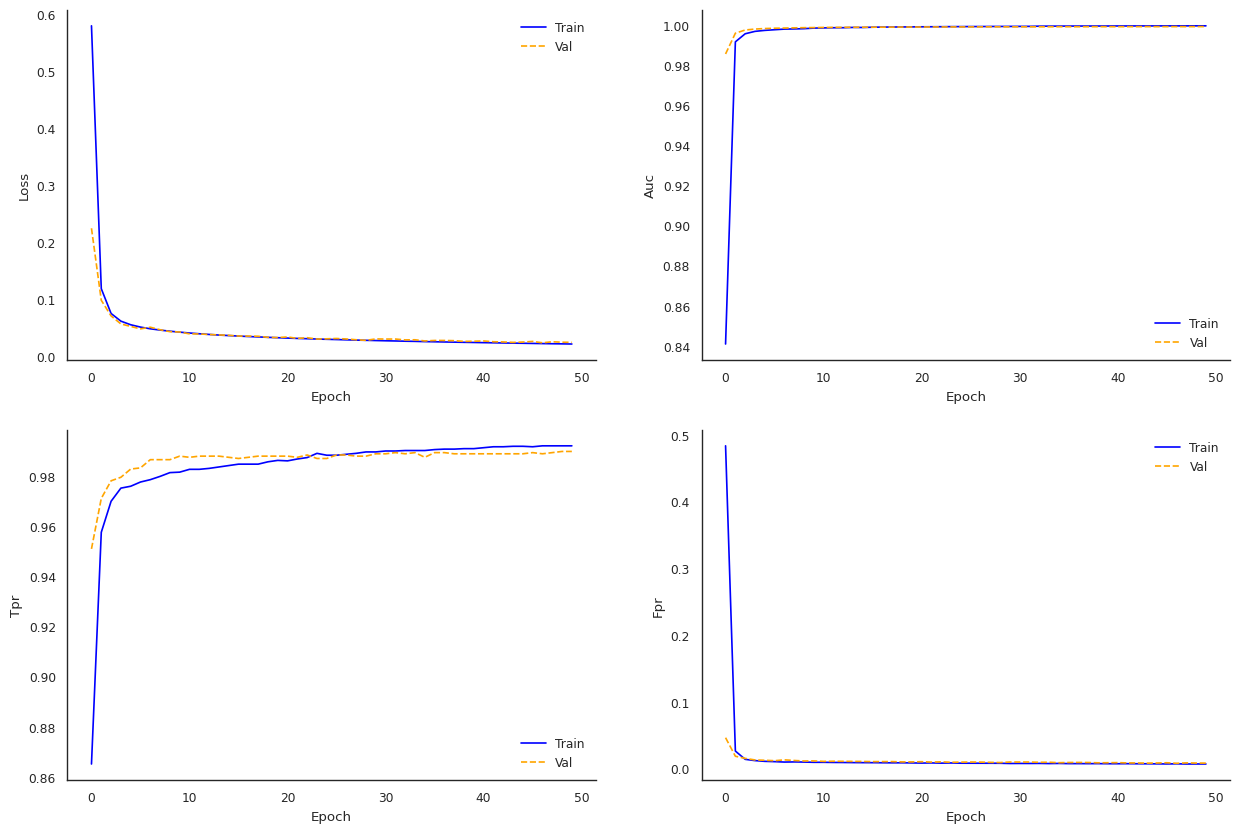

In [ ]:
# learning rate .00001
plot_metrics(history_MLP_nobias_lr, validation=True)

##### Predictions

In [ ]:
predictions_MLP_nobias_lr = np.ndarray.flatten((model_MLP_nobias_lr.predict(X_test, batch_size=128) > 0.5)).astype("int32")

print("ReLu activation functions: Shape for predictions {} equals shape of the ground truth {}".format(predictions_MLP_nobias_lr.shape, y_test.shape))

4342/4342 [==============================] - 6s 1ms/step
ReLu activation functions: Shape for predictions (555719,) equals shape of the ground truth (555719,)


##### Confusion matrix

In [ ]:
# learning rate .0001
cm = conf_matrix_clf_report(y_test, predictions_MLP_nobias_lr, scores_MLP_nobias_lr, print_info=True)

F1 score: 0.884
AUC score: 0.996
TPR rate: 97.949%
FPR rate: 0.092%
BER score: 0.011
G-mean score: 0.989




,precision,recall,f1-score,support
0,0.999920,0.999082,0.999501,553574.000000
1,0.805289,0.979487,0.883887,2145.000000
accuracy,0.999007,0.999007,0.999007,0.999007
macro avg,0.902605,0.989285,0.941694,555719.000000
weighted avg,0.999169,0.999007,0.999055,555719.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),553066.0,508.0
fraud (true),44.0,2101.0


In [ ]:
# learning rate .00001
cm = conf_matrix_clf_report(y_test, predictions_MLP_nobias_lr, scores_MLP_nobias_lr, print_info=True)

F1 score: 0.544
AUC score: 0.999
TPR rate: 97.949%
FPR rate: 0.629%
BER score: 0.013
G-mean score: 0.987




,precision,recall,f1-score,support
0,0.999920,0.993710,0.996805,553574.000000
1,0.376321,0.979487,0.543737,2145.000000
accuracy,0.993655,0.993655,0.993655,0.993655
macro avg,0.688120,0.986599,0.770271,555719.000000
weighted avg,0.997513,0.993655,0.995057,555719.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),550092.0,3482.0
fraud (true),44.0,2101.0


#### MLP with initial bias

In this model, I will explore if adding the initial bias helps to improve model generalization. I will explore the results with learning rates of .0001 and .00001.

**RESULTS**

Adding the initial bias to the output layer contributes to improve the loss and matrics of the validation set, making it to look more like the training metrics.

*Note: I have also tried to increase the weight of the positive class to try to increase TPs and reduce FPs. However, increasing it by 1.2 and 1.5 didn't help much*

In the following plots, you can see the evolution of the loss and metrics using both learning rates.

* Learning rate .0001: using the initial bias does helps to reduce the FPR in the test set.

* Learning rate .00001: seems to be reducing the FPR, although it is much higher compared to a learning rate of .0001.

Based on this, I will keep a learning rate at the level of .0001 as it offers a higher TPR and lower FPR, and try to reduce overfitting using regularization techniques (dropout between 0.1 and 0.3). However, we will remove the initial bias as it does not seem to help much.

In [ ]:
tf.keras.backend.clear_session()

# dictionary to store results
out_bias = {}

# iterate over dictionary with different activation functions and initializers
for activation, initilization in activations_initilizations.items():
    model, scores, history = model_MLP(activation, initilization, OUTPUT_BIAS, NUM_CLASSES, .00001, False, THRESHOLDS, CLASS_WEIGHTS)
    out_bias[activation] = [model, scores, history]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2560      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
7368/7368 [==============================] - 51s 6ms/step - loss: 0.5694 - tp: 310979.2812 - fp: 1422.5553 - tn: 470067.1562 - fn: 160517.5156 - auc: 0.9231 - val_loss: 0.0616 - val_tp: 1942.0000 - val_fp: 3207.0000 - val_tn: 345881.0000 - val_fn: 197.0000 - val_auc: 0.9944
Epoch 2/50
7368/7368 [==============================] - 46s 6ms/step - loss: 0.1003 - tp: 443439.7500 - fp: 5551.1357 - tn: 465927.0938 - fn: 28061.6758 - auc: 0.9949 - val_loss: 0.0767 - val_tp: 2074.0000 - val_fp: 4443.0000 - val_tn: 344645.0000 - val_fn: 65.0000 - val_auc: 0.9971
Epoch 3/50
7368/7368 [==============================] - 50s 7ms/step - loss: 0.0715 - tp: 455529.6875 - fp: 4873.2334 - tn: 466606.6562 - fn: 15972.2246 - auc: 0.9969 - val_loss: 0.0693 - val_tp: 2099.0000 - val_fp: 4018.0000 - val_tn: 345070.0000 - val_fn: 40.0000 - val_auc: 0.9978
Epoch 4/50
7368/7368 [==============================] - 50s 7ms/step - loss: 0.0606 - tp: 459148.4062 - fp: 4439.7310 - tn: 467043.6875 - fn: 1235

In [ ]:
# extract model, scores and history from the model
model_MLP_bias, scores_MLP_bias, history_MLP_bias = out_bias["relu"]

##### Plot results

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


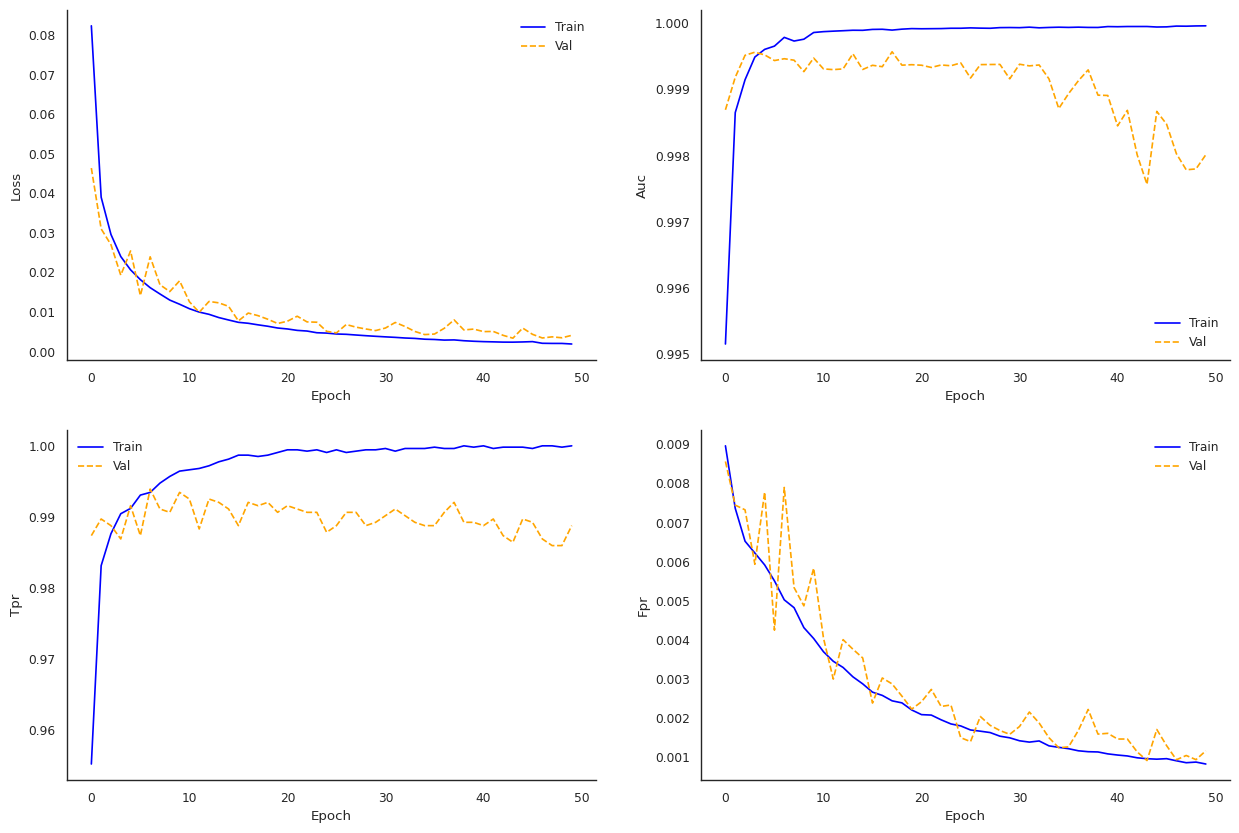

In [ ]:
# learning rate .0001 + output bias
plot_metrics(history_MLP_bias, validation=True)

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


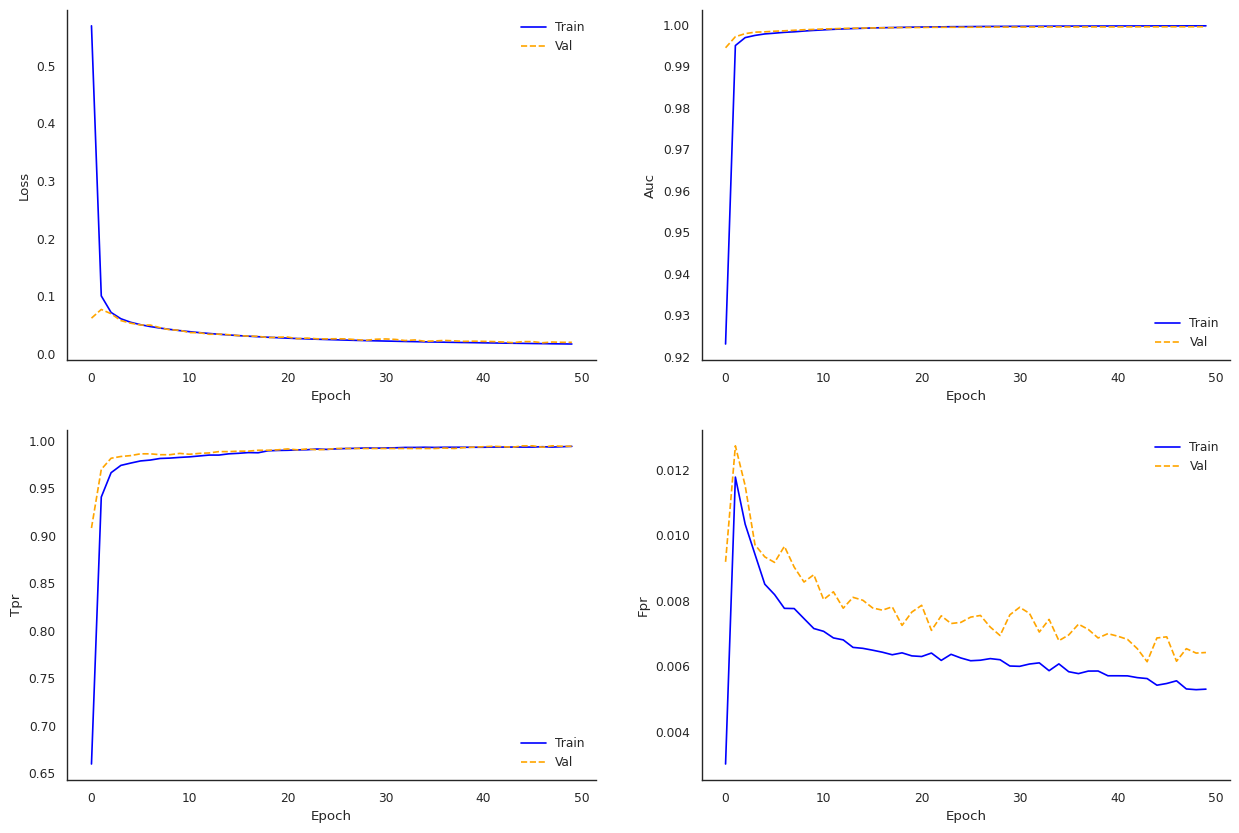

In [ ]:
# learning rate .00001 + output bias
plot_metrics(history_MLP_bias, validation=True)

##### Predictions

In [ ]:
predictions_MLP_bias = np.ndarray.flatten((model_MLP_bias.predict(X_test, batch_size=128) > 0.5)).astype("int32")

print("ReLu activation functions: Shape for predictions {} equals shape of the ground truth {}".format(predictions_MLP_bias.shape, y_test.shape))

4342/4342 [==============================] - 6s 1ms/step
ReLu activation functions: Shape for predictions (555719,) equals shape of the ground truth (555719,)


##### Confusion matrix

In [ ]:
# learning rate .0001 + output bias
cm = conf_matrix_clf_report(y_test, predictions_MLP_bias, scores_MLP_bias, print_info=True)

F1 score: 0.885
AUC score: 0.996
TPR rate: 97.995%
FPR rate: 0.091%
BER score: 0.01
G-mean score: 0.989




,precision,recall,f1-score,support
0,0.999922,0.999095,0.999508,553574.000000
1,0.807530,0.979953,0.885425,2145.000000
accuracy,0.999021,0.999021,0.999021,0.999021
macro avg,0.903726,0.989524,0.942467,555719.000000
weighted avg,0.999180,0.999021,0.999068,555719.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),553073.0,501.0
fraud (true),43.0,2102.0


In [ ]:
# learning rate .00001 + output bias
cm = conf_matrix_clf_report(y_test, predictions_MLP_bias, scores_MLP_bias, print_info=True)

F1 score: 0.61
AUC score: 0.999
TPR rate: 98.228%
FPR rate: 0.48%
BER score: 0.011
G-mean score: 0.989




,precision,recall,f1-score,support
0,0.999931,0.995204,0.997562,553574.000000
1,0.442461,0.982284,0.610106,2145.000000
accuracy,0.995154,0.995154,0.995154,0.995154
macro avg,0.721196,0.988744,0.803834,555719.000000
weighted avg,0.997779,0.995154,0.996066,555719.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),550919.0,2655.0
fraud (true),38.0,2107.0


#### MLP + dropout

Although a I don't see that the model is overfitting, I will try small dropout rates between .1 and .2 to see if it helps to improve performance.

We will try its performance in the model with a learning rate of .00001, and also the same model with the initial bias.

**RESULTS**

With a dropout rate of 0.1 and 0.2, it seems that there is a slight overfit in the AUC and TPR towards 50 epochs. It is possible that the overfit increase if we keep training for longer. As this overfit seems to decrease with a dropout rate of 0.3, I will decide to go with this dropout rate and we will try different decision thresholds.

In [ ]:
tf.keras.backend.clear_session()

# dictionary to store results
out_bias_dpt = {}

# iterate over dictionary with different activation functions and initializers
for activation, initilization in activations_initilizations.items():
    model, scores, history = model_MLP(activation, initilization, None, NUM_CLASSES, .00001, True, THRESHOLDS, CLASS_WEIGHTS)
    out_bias_dpt[activation] = [model, scores, history]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2560      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
7368/7368 [==============================] - 54s 7ms/step - loss: 0.3671 - tp: 448911.1875 - fp: 149131.7344 - tn: 322354.3438 - fn: 22590.5352 - auc: 0.9536 - val_loss: 0.2055 - val_tp: 2064.0000 - val_fp: 10879.0000 - val_tn: 338209.0000 - val_fn: 75.0000 - val_auc: 0.9918
Epoch 2/50
7368/7368 [==============================] - 45s 6ms/step - loss: 0.1188 - tp: 450852.6875 - fp: 9563.1816 - tn: 461910.1875 - fn: 20649.1641 - auc: 0.9913 - val_loss: 0.0998 - val_tp: 2087.0000 - val_fp: 4885.0000 - val_tn: 344203.0000 - val_fn: 52.0000 - val_auc: 0.9965
Epoch 3/50
7368/7368 [==============================] - 47s 6ms/step - loss: 0.0827 - tp: 455794.4062 - fp: 6338.1558 - tn: 465137.6250 - fn: 15707.4922 - auc: 0.9947 - val_loss: 0.0751 - val_tp: 2100.0000 - val_fp: 4514.0000 - val_tn: 344574.0000 - val_fn: 39.0000 - val_auc: 0.9976
Epoch 4/50
7368/7368 [==============================] - 48s 7ms/step - loss: 0.0722 - tp: 456765.7188 - fp: 6289.8755 - tn: 465186.0312 - fn: 147

In [ ]:
# extract model, scores and history from the model
model_MLP_bias_dpt, scores_MLP_bias_dpt, history_MLP_bias_dpt = out_bias_dpt["relu"]

##### Plot results

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


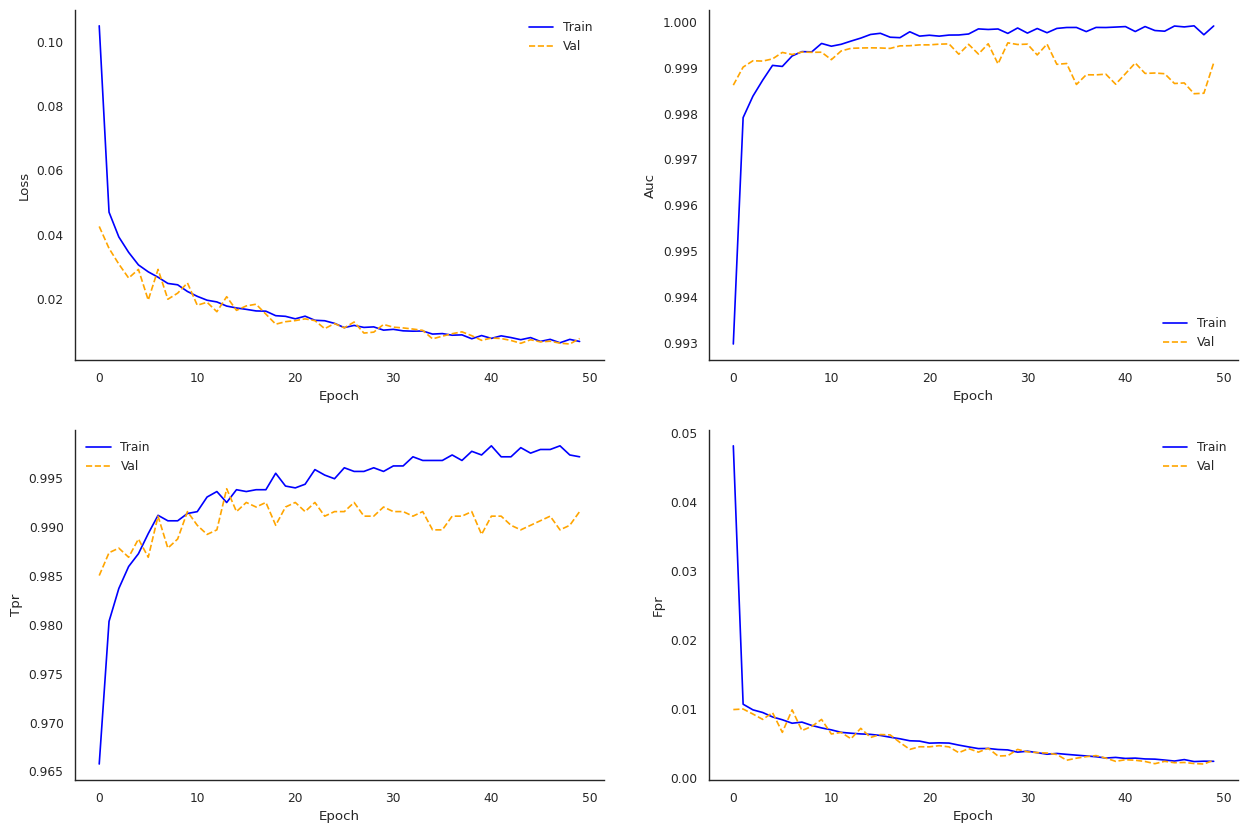

In [ ]:
# learning rate .0001 + dropout 0.1
plot_metrics(history_MLP_no_bias_dpt, validation=True)

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


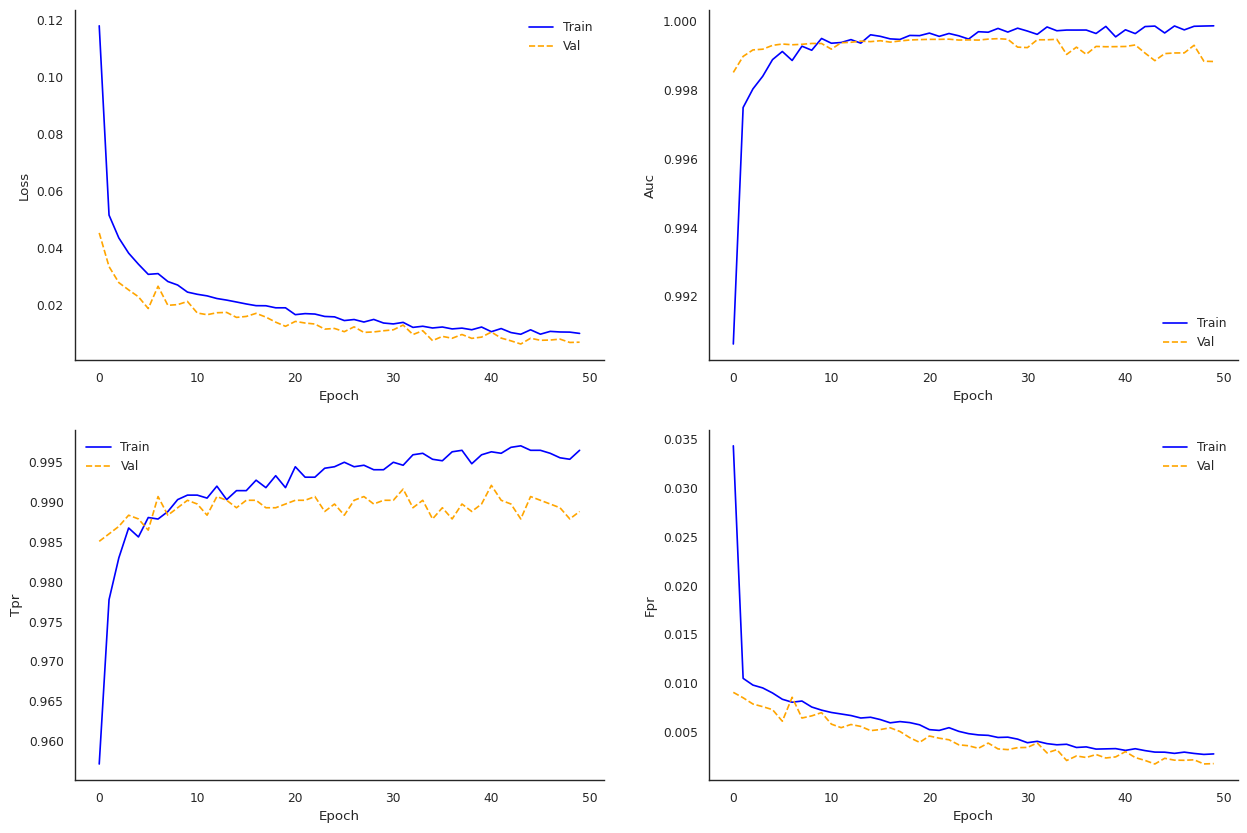

In [ ]:
# learning rate .0001 + dropout 0.2
plot_metrics(history_MLP_no_bias_dpt, validation=True)

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


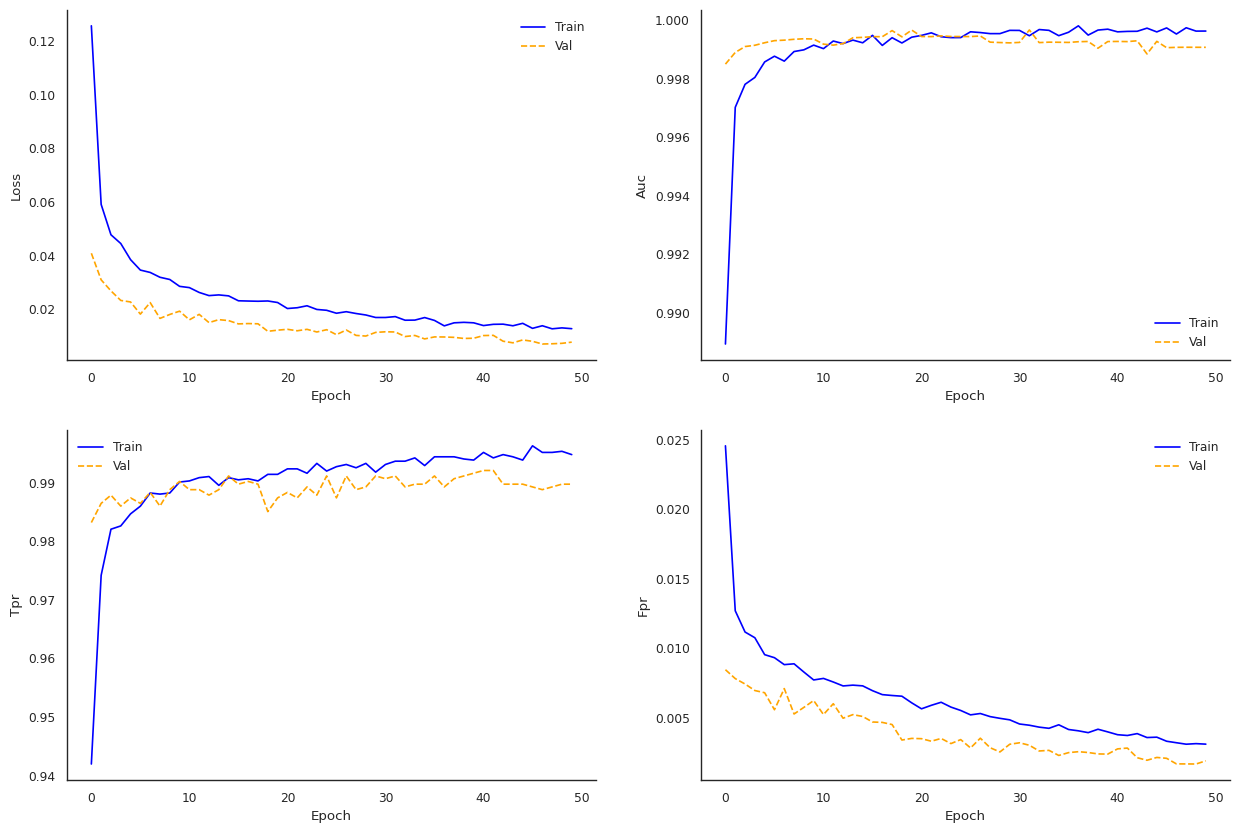

In [ ]:
# learning rate .0001 + dropout 0.3
plot_metrics(history_MLP_no_bias_dpt, validation=True)

##### Predictions

In [ ]:
predictions_MLP_bias_dpt = np.ndarray.flatten((model_MLP_bias_dpt.predict(X_test, batch_size=128) > 0.5)).astype("int32")

print("ReLu activation functions: Shape for predictions {} equals shape of the ground truth {}".format(predictions_MLP_bias_dpt.shape, y_test.shape))

4342/4342 [==============================] - 7s 2ms/step
ReLu activation functions: Shape for predictions (555719,) equals shape of the ground truth (555719,)


##### Confusion matrix

In [ ]:
# dropout 0.1
cm = conf_matrix_clf_report(y_test, predictions_MLP_no_bias_dpt, scores_MLP_no_bias_dpt, print_info=True)

F1 score: 0.795
AUC score: 0.997
TPR rate: 98.228%
FPR rate: 0.19%
BER score: 0.01
G-mean score: 0.99




,precision,recall,f1-score,support
0,0.999931,0.998103,0.999016,553574.000000
1,0.667406,0.982284,0.794794,2145.000000
accuracy,0.998042,0.998042,0.998042,0.998042
macro avg,0.833668,0.990194,0.896905,555719.000000
weighted avg,0.998648,0.998042,0.998228,555719.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),552524.0,1050.0
fraud (true),38.0,2107.0


In [ ]:
# dropout 0.2
cm = conf_matrix_clf_report(y_test, predictions_MLP_no_bias_dpt, scores_MLP_no_bias_dpt, print_info=True)

F1 score: 0.831
AUC score: 0.997
TPR rate: 98.089%
FPR rate: 0.147%
BER score: 0.01
G-mean score: 0.99




,precision,recall,f1-score,support
0,0.999926,0.998533,0.999229,553574.000000
1,0.721536,0.980886,0.831456,2145.000000
accuracy,0.998465,0.998465,0.998465,0.998465
macro avg,0.860731,0.989709,0.915343,555719.000000
weighted avg,0.998851,0.998465,0.998581,555719.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),552762.0,812.0
fraud (true),41.0,2104.0


In [ ]:
# dropout 0.3
cm = conf_matrix_clf_report(y_test, predictions_MLP_no_bias_dpt, scores_MLP_no_bias_dpt, print_info=True)

F1 score: 0.829
AUC score: 0.998
TPR rate: 97.949%
FPR rate: 0.149%
BER score: 0.011
G-mean score: 0.989




,precision,recall,f1-score,support
0,0.999920,0.998513,0.999216,553574.00000
1,0.718536,0.979487,0.828960,2145.00000
accuracy,0.998440,0.998440,0.998440,0.99844
macro avg,0.859228,0.989000,0.914088,555719.00000
weighted avg,0.998834,0.998440,0.998559,555719.00000


,non-fraud (pred),fraud (pred)
non-fraud (true),552751.0,823.0
fraud (true),44.0,2101.0


### Try different decision thresholds

Once completed these series of steps during model building, I have reached the conclusion that the model with a learning rate of .0001 and the initial bias is the one that offers a better generalizability. Using this model, I will try different thresholds in order to explore if a higher threshold allows to improve model generalization.

For this, I have specified a list of thresholds to try. I will include them in the 'thresholds' parameter of Tensorflow metrics. I have also built a custom function that will return the scores for each threshold in the test set in a pandas DataFrame.


In [ ]:
THRESHOLDS = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1]

In [ ]:
tf.keras.backend.clear_session()

model_MLP_thresholds, scores_MLP_thresholds, history_MLP_thresholds = model_MLP("relu", HE_INIT, None, NUM_CLASSES, .0001, True, THRESHOLDS, CLASS_WEIGHTS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2560      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
7368/7368 [==============================] - 48s 6ms/step - loss: 0.1352 - tp: 441145.1250 - fp: 30823.3926 - tn: 440660.2812 - fn: 30356.1504 - auc: 0.9833 - val_loss: 0.0468 - val_tp: 2103.2942 - val_fp: 5524.8823 - val_tn: 343563.1250 - val_fn: 35.7059 - val_auc: 0.9961
Epoch 2/50
7368/7368 [==============================] - 44s 6ms/step - loss: 0.0554 - tp: 459537.3125 - fp: 8886.3799 - tn: 462596.9688 - fn: 11964.8984 - auc: 0.9937 - val_loss: 0.0385 - val_tp: 2110.1765 - val_fp: 4880.7646 - val_tn: 344207.2500 - val_fn: 28.8235 - val_auc: 0.9970
Epoch 3/50
7368/7368 [==============================] - 44s 6ms/step - loss: 0.0443 - tp: 461982.1250 - fp: 7293.5957 - tn: 464188.1250 - fn: 9520.0117 - auc: 0.9952 - val_loss: 0.0322 - val_tp: 2112.4119 - val_fp: 4368.2354 - val_tn: 344719.7500 - val_fn: 26.5882 - val_auc: 0.9973
Epoch 4/50
7368/7368 [==============================] - 44s 6ms/step - loss: 0.0391 - tp: 463249.2500 - fp: 6751.1108 - tn: 464731.3125 - fn: 8253.4

#### Compare thresholds

**RESULTS**

I see that a threshold of .50, which is the one that Tensorflow metrics use by default, returns a TPR of 97.99 and a FPR of .20

I will use a threshold of .70, as although the decrease in TPR, the gain in FPR seems much higher. It should be noted that a threshold of .90 will significantly reduce the number of FPs from 1140 to 257 (∆883), while the decrease in TPs decrease from 2102 to 2082 (∆20). We could definitely use this threshold but I do not know if it is too extreme, as we will decreasing the TPR from almost 98% to 97% (∆1%).

We will keep a threshold of .70 and perform some hyperparameter tuning to see if we can decrease the FPR.

In [ ]:
get_scores_thresholds(THRESHOLDS, model_MLP_thresholds, scores_MLP_thresholds)

Working on result for threshold: 0.9
4342/4342 [==============================] - 7s 2ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.85
4342/4342 [==============================] - 7s 2ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.8
4342/4342 [==============================] - 6s 1ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.75
4342/4342 [==============================] - 7s 2ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.7
4342/4342 [==============================] - 7s 2ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.65
4342/4342 [==============================] - 6s 1ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.6
4342/4342 [==============================] - 7s 2ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.55
4342/4342 [==============================] - 7s 2ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.5
4342/4342 [==============================] - 6s 1ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.45
4342/4342 [==============================] - 7s 2ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.4
4342/4342 [==============================] - 6s 1ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.35
4342/4342 [==============================] - 7s 2ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.3
4342/4342 [==============================] - 6s 1ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.25
4342/4342 [==============================] - 7s 2ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.2
4342/4342 [==============================] - 7s 2ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.15
4342/4342 [==============================] - 6s 1ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Working on result for threshold: 0.1
4342/4342 [==============================] - 6s 1ms/step


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,TP,FP,TN,FN,TPR,FPR,FNR,TNR,BER,G-mean,F1_micro,AUC
Threshold,,,,,,,,,,,,
0.90,2082.0,257.0,553317.0,63.0,97.062939,0.046426,2.937063,99.953574,0.014917,9.849765,0.999,0.985
0.85,2086.0,360.0,553214.0,59.0,97.249418,0.065032,2.750583,99.934965,0.014078,9.858305,0.999,0.986
0.80,2088.0,465.0,553109.0,57.0,97.342658,0.084000,2.657343,99.915999,0.013707,9.862094,0.999,0.986
0.75,2094.0,559.0,553015.0,51.0,97.622377,0.100980,2.377622,99.899018,0.012393,9.875414,0.999,0.988
0.70,2096.0,653.0,552921.0,49.0,97.715616,0.117961,2.284382,99.882036,0.012012,9.879289,0.999,0.988
0.65,2098.0,748.0,552826.0,47.0,97.808856,0.135122,2.191142,99.864876,0.011631,9.883152,0.999,0.988
0.60,2100.0,882.0,552692.0,45.0,97.902095,0.159328,2.097902,99.840671,0.011286,9.886663,0.998,0.989
0.55,2101.0,997.0,552577.0,44.0,97.948718,0.180102,2.051282,99.819899,0.011157,9.887988,0.998,0.989
0.50,2102.0,1140.0,552434.0,43.0,97.995341,0.205935,2.004662,99.794066,0.011053,9.889061,0.998,0.989


#### Save model

In [ ]:
# # save on Jupyter Notebook
# model_MLP_thresholds.save(os.path.join(os.getcwd(), ".models/MLP_thresholds"))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/.models/relu_thresholds/assets


In [ ]:
# save on Google Colab
model_MLP_thresholds.save(os.path.join(models_path_gd, "tf_MLP_thresholds"))

#### Load model

In [ ]:
# load on Jupyter Notebook
#model_relu_thresholds = tf.keras.models.load_model(os.path.join(save_model, "relu_thresholds"))

In [ ]:
# load on Google Colab
model_MLP_thresholds = tf.keras.models.load_model(os.path.join(models_path_gd, "tf_MLP_thresholds"))

## Hyperparameter tuning

In this step, I am going to try to find the best hyperparameters using RandomSearch, as it much faster and generally returns good results. Also, the performance of the current model seems quite good, so I do not need such an exhaustive search.

I am going to tune the number of neurons of the dense layers, the learning rate and also the dropout rate at it seems that it could improve model performance.

The search will focus on finding the best hyperparameters that minimize the loss in the validation set, using 3 executions per trial in order to get more accurate results reducing the variability of just one execution per trial. Due to GPU limitation, I will reduce the number of maximum trials to 10.

The searching range of neurons for the dense layers will be set between 32 and 128, which is the size of our batch size. Learning rate will be between .0001 and .00001, while dropout rate will be 0, 0.1, 0.2 or 0.3. A threshold of .70 will be considered.

In [ ]:
THRESHOLDS_HP = [.70]

In [ ]:
def model_tune_hp(hp):

  hp_units = hp.Int("units", min_value=32, max_value=128, step=16)
  hp_dropout_rate = hp.Choice("dropout_rate", values=[0., 0.1, 0.2, 0.3]) # there is not such a huge overfitting to try higher dropout values
  hp_learning_rate = hp.Choice("learning_rate", values=[1e-4, 1e-5]) # minimum learning rate value set to .001

  # model architecture
  model = tf.keras.Sequential()
  # input
  model.add(tf.keras.Input(shape=(X_train.shape[-1])))
  # dense 1
  model.add(tf.keras.layers.Dense(hp_units,
                                  activation="relu",
                                  kernel_initializer=HE_INIT))
  # dropout 1
  model.add(tf.keras.layers.Dropout(hp_dropout_rate))
  # dense 2
  model.add(tf.keras.layers.Dense(hp_units,
                                  activation="relu",
                                  kernel_initializer=HE_INIT))
  # output arrays of shape (None, num_classes)
  model.add(tf.keras.layers.Dense(NUM_CLASSES,
                                  activation="sigmoid"))

  # compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(
                    learning_rate=hp_learning_rate,
                    beta_1=0.9,
                    beta_2=0.999
                    ),
                weighted_metrics=[tf.keras.metrics.TruePositives(name="tp", thresholds=THRESHOLDS_HP),
                                  tf.keras.metrics.FalsePositives(name="fp", thresholds=THRESHOLDS_HP),
                                  tf.keras.metrics.TrueNegatives(name="tn", thresholds=THRESHOLDS_HP),
                                  tf.keras.metrics.FalseNegatives(name="fn", thresholds=THRESHOLDS_HP),
                                  tf.keras.metrics.AUC(name="auc", curve="ROC", thresholds=THRESHOLDS_HP)])

  return model

In [ ]:
# trained model 04/06/2023
tf.keras.backend.clear_session()

# select tuner
tuner = select_tuner("RandomSearch", model_tune_hp, "tf_MLP_RandomSearch_2")

# initiate search
tuner.search(x=X_train,
             y=y_train,
             epochs=10,
             batch_size=128,
             validation_data=(X_val, y_val),
             verbose=1,
             class_weight=CLASS_WEIGHTS)

Trial 10 Complete [00h 12m 09s]
val_loss: 0.018896987040837605

Best val_loss So Far: 0.013676428546508154
Total elapsed time: 01h 42m 41s


In [ ]:
hp_names = ["units", "dropout_rate", "learning_rate"]
best_hps = {}

for name in hp_names:
  best_hps[name] = tuner.get_best_hyperparameters()[0].get(name)
  print("Best {}: {}".format(name, tuner.get_best_hyperparameters()[0].get(name)))

Best units: 96
Best dropout_rate: 0.0
Best learning_rate: 0.0001


### Model with best hyperparameters

In [ ]:
# get the best hyperparameters
best_hps_to_train = tuner.get_best_hyperparameters()[0]

# build the model with the best hp
model_best_hps = model_tune_hp(best_hps_to_train)

# retrain the model
history_best_hp = model_best_hps.fit(x=X_train,
                                     y=y_train,
                                     epochs=50,
                                     batch_size=128,
                                     validation_data=(X_val, y_val),
                                     verbose=1,
                                     class_weight=CLASS_WEIGHTS)

Epoch 1/50
7368/7368 [==============================] - 21s 3ms/step - loss: 0.0667 - tp: 454117.6875 - fp: 3767.9028 - tn: 467725.8125 - fn: 17384.1309 - auc: 0.9776 - val_loss: 0.0418 - val_tp: 2101.0000 - val_fp: 2533.0000 - val_tn: 346555.0000 - val_fn: 38.0000 - val_auc: 0.9875
Epoch 2/50
7368/7368 [==============================] - 20s 3ms/step - loss: 0.0351 - tp: 460824.6875 - fp: 2605.2678 - tn: 468886.3125 - fn: 10677.5762 - auc: 0.9859 - val_loss: 0.0329 - val_tp: 2101.0000 - val_fp: 2228.0000 - val_tn: 346860.0000 - val_fn: 38.0000 - val_auc: 0.9879
Epoch 3/50
7368/7368 [==============================] - 20s 3ms/step - loss: 0.0284 - tp: 463913.1875 - fp: 2376.9604 - tn: 469114.5000 - fn: 7589.0269 - auc: 0.9894 - val_loss: 0.0314 - val_tp: 2112.0000 - val_fp: 2179.0000 - val_tn: 346909.0000 - val_fn: 27.0000 - val_auc: 0.9906
Epoch 4/50
7368/7368 [==============================] - 20s 3ms/step - loss: 0.0236 - tp: 464796.0938 - fp: 2053.6064 - tn: 469440.3750 - fn: 6706.58

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


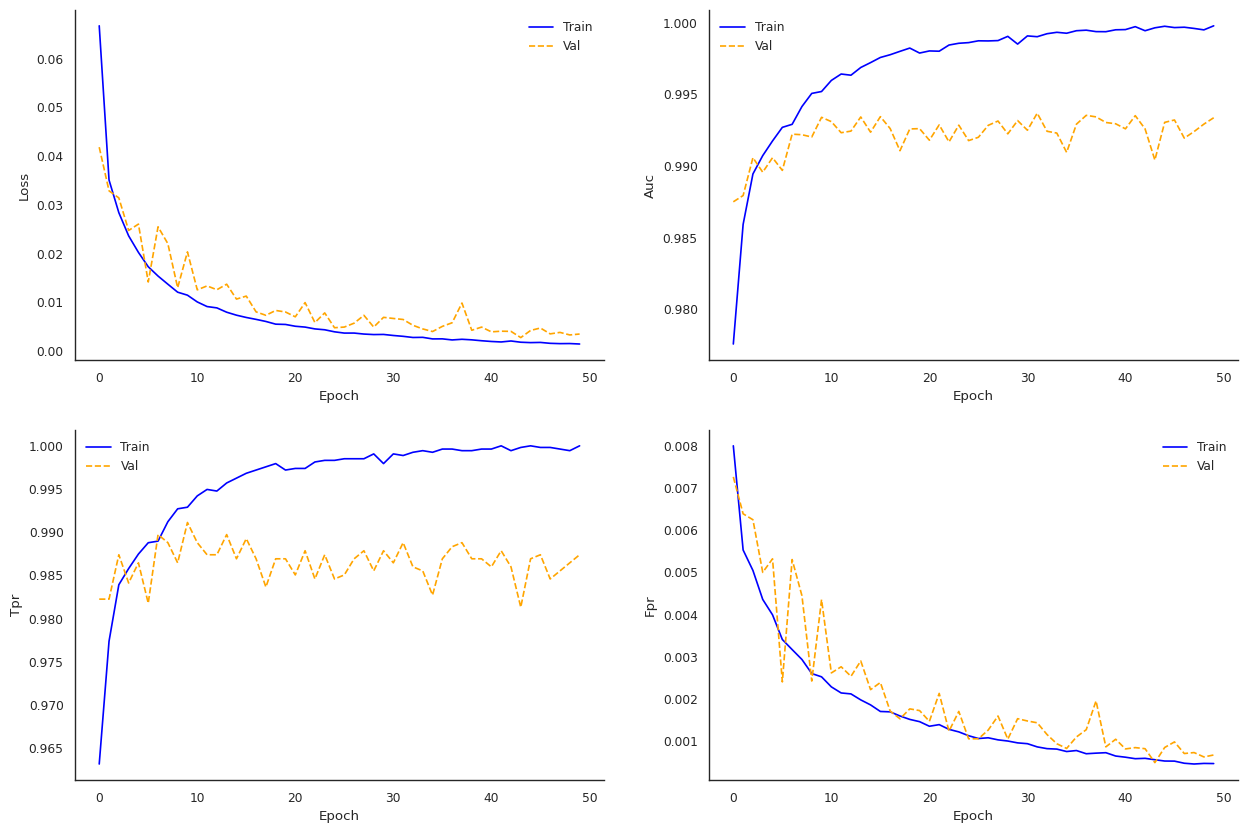

In [ ]:
# RandomSearch with a learning rate of .0001 and dropout rate of 0.1
plot_metrics(history_best_hp, validation=True)

### Save model

In [ ]:
# save on Colab
model_best_hps.save(os.path.join(models_path_gd, "tf_ReLu_best_hps_2"))

### Load model

In [ ]:
# load model on Colab
model_best_hps = tf.keras.models.load_model(os.path.join(models_path_gd, "tf_ReLu_best_hps_2"))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Predictions and results

In this very limited hyperparameter optimization using Random Search, I tried to optimize the number of neurons in the Dense layers, the learning and dropout rate, using a pre-selected threshold of .70.

In the plots for the train and validation metrics we can see a slight overfit, but it is possible that is difference is visually augmented due to the scale of the plots in the Y axis, as in the AUC the difference between both sets is of around .001

* As a result, we can see that we have reduced the FPR to .06%, while the TPR keeps being good 97.57%

* Going for a higher threshold will probably lead to a higher decrease in TPR, yet maybe decreasing FPR too. But as I want to improve Boosting models performance, I don't want to decrease the TPR too much. In general terms, this seems as an acceptable model.

Perhaps with a more exahustive search I could end up with a model with a higher performance. For this I could still use Random Search increasing the number of trials, or either try other approaches such as Hyperband or Bayesian Optimization.

In [ ]:
# get model predictions for train, test and validation sets
predictions_test_best_hps = np.ndarray.flatten((model_best_hps.predict(X_test, batch_size=128) > .70)).astype("int32")

4342/4342 [==============================] - 4s 881us/step


In [ ]:
# get scores for the train, test and validation sets
scores_test_best_hps = model_best_hps.evaluate(X_test, y_test, verbose=1)

# pass scores to dictionary for train, test and validation sets
dict_scores_test_best_hps = {"loss": scores_test_best_hps[0],
                             "tp": scores_test_best_hps[1],
                             "fp": scores_test_best_hps[2],
                             "tn": scores_test_best_hps[3],
                             "fn": scores_test_best_hps[4],
                             "auc": scores_test_best_hps[5]}

17367/17367 [==============================] - 20s 1ms/step - loss: 0.0032 - tp: 2093.0000 - fp: 330.0000 - tn: 553244.0000 - fn: 52.0000 - auc: 0.9876


In [ ]:
# confusion matrix for the test set
conf_matrix_clf_report(y_test, predictions_test_best_hps, dict_scores_test_best_hps, print_info=True)

F1 score: 0.916
AUC score: 0.988
TPR rate: 97.576%
FPR rate: 0.06%
BER score: 0.012
G-mean score: 0.988




,precision,recall,f1-score,support
0,0.999906,0.999404,0.999655,553574.000000
1,0.863805,0.975758,0.916375,2145.000000
accuracy,0.999313,0.999313,0.999313,0.999313
macro avg,0.931856,0.987581,0.958015,555719.000000
weighted avg,0.999381,0.999313,0.999333,555719.000000


,non-fraud (pred),fraud (pred)
non-fraud (true),553244.0,330.0
fraud (true),52.0,2093.0


### Feature importances

To check features importances I am going to sample 5000 random instances.

I can see that *lag_fraud* accounts for most the importance in model predictions.

Similarly to XGBoost, *cumsum_amt_day*, *cumcount_trans_day*, *amt_week_quarter* and *distance* also have importance on model predictions although much lower compared to *lag_fraud*.

Other predictors such as *total_seconds_day* and *hour* have a much lower importance comparted to boosting models.

In general, feature importances make sense with those found for the boosting models trained in the previous notebook.

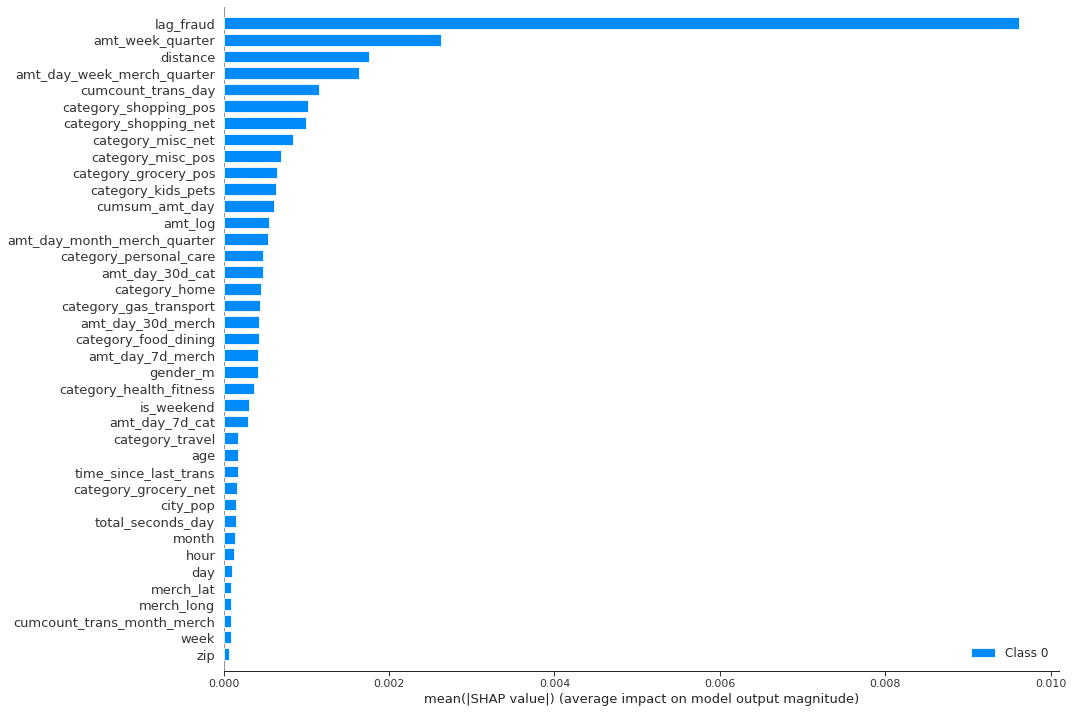

In [ ]:
# select a random sample
train_rs = X_train_df.sample(n=5000, random_state=42).values

# use DeepExplainer
explainer = shap.DeepExplainer(model_best_hps, train_rs)

# get shap values
shap_values = explainer.shap_values(train_rs)

# get summary bar plot
shap.summary_plot(shap_values, X_test_df.sample(n=5000),
                  max_display=len(X_train_df.columns), plot_type="bar",
                  plot_size=(15, 10))

In [ ]:
train_rs.median().values.reshape((1, train_rs.shape[1])).shape

(1, 39)

Permutation explainer: 5001it [02:36, 30.30it/s]                          


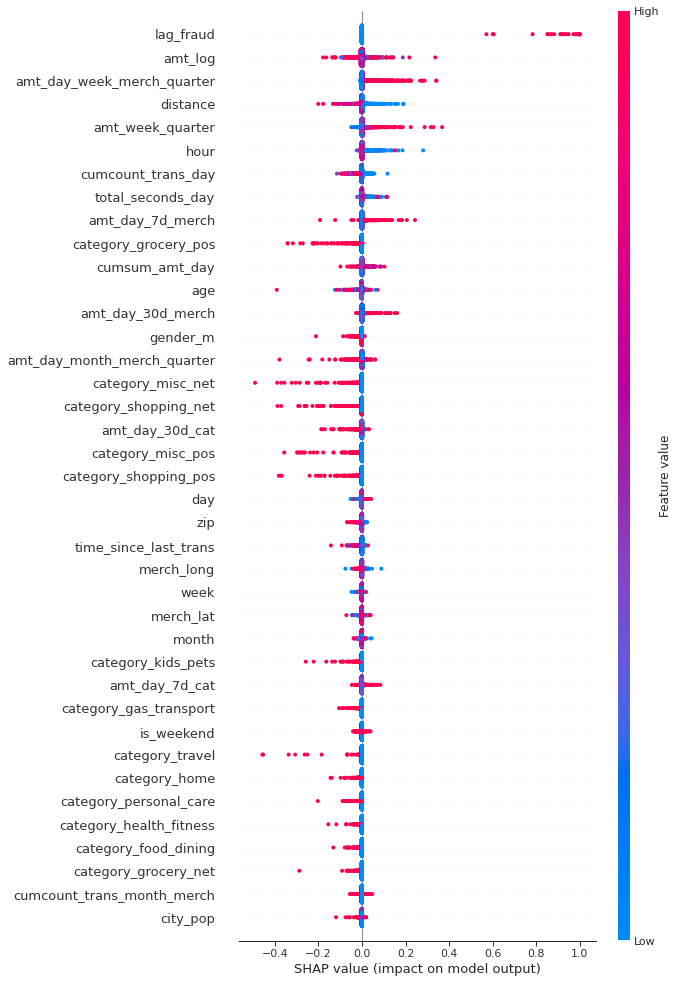

In [ ]:
f = lambda x: model_best_hps.predict(x, batch_size=128)

# select a random sample
train_rs = X_train_df.sample(n=5000, random_state=42)#.values

med = train_rs.median().values.reshape((1, train_rs.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(train_rs)

shap.plots.beeswarm(shap_values, max_display=train_rs.columns.shape[0])

# Conclusions and next steps

In this notebook I have built a MLP model. I have considered and retain initial bias in the model and dropout rate as they contributed to a more stable model.

Hyperparameter tuning contributed to reduce the False Positives but not to increase True Positives. Nevertheless our grid search was quite limited. In general, using a wider set of hyperparameters to search on would probably lead to a significant improvement in performance.

I can see that boosting models ourperform our MLP model:

* AUC score for **MLP (.988)** is smaller than for XGBoost (.991) and LightGBM (.990).

* True Positive Rate for **MLP (97.57%)** is also smaller compared to XGBoost (98.27%) and LightGBM (98.08%)

* False Positive Rate for is higher for **MLP (0.06%)** compared to XGBoost (0.005%) and LightGBM (.005%)

Finally, feature importances makes sense compared to those for boosting models, yet some differences are noticeable.

In the next notebook I will train a Long-Short Term Memory and compare its performance to boosting and MLP models.